In [1]:
import os,sys, glob, natsort
import argparse
from path import Path
from natsort import natsorted
from easydict import EasyDict
import json
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from tqdm.auto import tqdm
import logging

import cv2
from scipy import ndimage
from PIL import Image
import SimpleITK as sitk
from skimage.transform import resize

import torchvision
from torchvision import transforms as T
from torchvision.datasets.folder import default_loader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.2.0
Numpy version: 1.25.2
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/pwrai/userarea/KTL_project_07_Pathology_BreastCancer_Classification/Code/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.15.2+cu117
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 6.1.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.21.3
mlflow version: 2.18.0
pynrrd version: 1.1.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
base_dir = '../Data'
folder_list = natsorted(os.listdir(base_dir))

print(len(folder_list))

279


In [4]:
x_normal = []
x_cancer = []

for idx in tqdm(range(len(folder_list))):
    sam_normal_list = natsorted(glob.glob(base_dir + '/' + folder_list[idx] + '/0/*.png'))
    for item in sam_normal_list:
        img = sitk.ReadImage(item)
        img = sitk.GetArrayFromImage(img)
        if img.shape != (50,50,3):
            continue
        x_normal.append(img)

for idx in tqdm(range(len(folder_list))):
    sam_cancer_list = natsorted(glob.glob(base_dir + '/' + folder_list[idx] + '/1/*.png'))
    for item in sam_cancer_list:
        img = sitk.ReadImage(item)
        img = sitk.GetArrayFromImage(img)
        if img.shape != (50,50,3):
            continue
        x_cancer.append(img)

x_normal = np.array(x_normal)
x_cancer = np.array(x_cancer)

print(x_normal.shape, x_normal.min(), x_normal.max(), x_normal.dtype)
print(x_cancer.shape, x_cancer.min(), x_cancer.max(), x_cancer.dtype)

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

(196219, 50, 50, 3) 0 255 uint8
(78768, 50, 50, 3) 0 255 uint8


In [5]:
y_normal = np.ones([len(x_normal),1], dtype=np.uint8)
y_cancer = np.zeros([len(x_cancer),1], dtype=np.uint8)

print(y_normal.shape, y_normal.min(), y_normal.max(), y_normal.dtype)
print(y_cancer.shape, y_cancer.min(), y_cancer.max(), y_cancer.dtype)

(196219, 1) 1 1 uint8
(78768, 1) 0 0 uint8


In [6]:
X_train_normal = x_normal[:int(np.round(len(x_normal)*0.6))]
X_val_normal = x_normal[int(np.round(len(x_normal)*0.6)):int(np.round(len(x_normal)*0.8))]
X_test_normal = x_normal[int(np.round(len(x_normal)*0.8)):]

X_train_cancer = x_cancer[:int(np.round(len(x_cancer)*0.6))]
X_val_cancer = x_cancer[int(np.round(len(x_cancer)*0.6)):int(np.round(len(x_cancer)*0.8))]
X_test_cancer = x_cancer[int(np.round(len(x_cancer)*0.8)):]

X_train = np.concatenate([X_train_normal, X_train_cancer], axis=0)
X_val = np.concatenate([X_val_normal, X_val_cancer], axis=0)
X_test = np.concatenate([X_test_normal, X_test_cancer], axis=0)

Y_train_normal = y_normal[:int(np.round(len(x_normal)*0.6))]
Y_val_normal = y_normal[int(np.round(len(x_normal)*0.6)):int(np.round(len(x_normal)*0.8))]
Y_test_normal = y_normal[int(np.round(len(x_normal)*0.8)):]

Y_train_cancer = y_cancer[:int(np.round(len(x_cancer)*0.6))]
Y_val_cancer = y_cancer[int(np.round(len(x_cancer)*0.6)):int(np.round(len(x_cancer)*0.8))]
Y_test_cancer = y_cancer[int(np.round(len(x_cancer)*0.8)):]

Y_train = np.concatenate([Y_train_normal, Y_train_cancer], axis=0)
Y_val = np.concatenate([Y_val_normal, Y_val_cancer], axis=0)
Y_test = np.concatenate([Y_test_normal, Y_test_cancer], axis=0)

print(X_train.shape, X_train.min(), X_train.max(), X_train.dtype)
print(Y_train.shape, Y_train.min(), Y_train.max(), Y_train.dtype)
print(X_val.shape, X_val.min(), X_val.max(), X_val.dtype)
print(Y_val.shape, Y_val.min(), Y_val.max(), Y_val.dtype)
print(X_test.shape, X_test.min(), X_test.max(), X_test.dtype)
print(Y_test.shape, Y_test.min(), Y_test.max(), Y_test.dtype)

(164992, 50, 50, 3) 0 255 uint8
(164992, 1) 0 1 uint8
(54997, 50, 50, 3) 0 255 uint8
(54997, 1) 0 1 uint8
(54998, 50, 50, 3) 0 255 uint8
(54998, 1) 0 1 uint8


In [7]:
del x_normal, x_cancer
del X_train_normal, X_val_normal, X_test_normal
del X_train_cancer, X_val_cancer, X_test_cancer
del Y_train_normal, Y_val_normal, Y_test_normal
del Y_train_cancer, Y_val_cancer, Y_test_cancer

del X_train, Y_train, X_val, Y_val

In [8]:
h_params=EasyDict()
h_params.gpu_num=0
h_params.seed=42
h_params.batch_size=256
h_params.model_name = "./output/model_final.pth"

device = torch.device(f"cuda:{h_params.gpu_num}" if torch.cuda.is_available() else 'cpu')

In [9]:
class custom_dataset(Dataset):
    def __init__(self, img, label, transform=None):
        self.img = img
        self.label = label
        self.transform = transform

    def __getitem__(self,idx):
        sample = {}
        
        sample['image'] = self.img[idx,...].copy()
        sample['image'] = sample['image'].astype(np.float32)
        sample['image'] /= 255.0
        
        sample['label'] = self.label[idx,...].copy()
        sample['label'] = sample['label'].astype(np.uint8)
        
        if transform is not None:
            transformed = self.transform(image=sample['image'])
            sample['image'] = transformed['image']
        
        return sample
        
    def __len__(self):
        return len(self.img)

In [10]:
transform = A.Compose([ToTensorV2()], p=1)

In [11]:
test_dataset = custom_dataset(img=X_test,
                              label=Y_test,
                              transform=transform)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=h_params.batch_size,
                             shuffle=False)

In [12]:
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=3, out_channels=1).to(device)

model = model.to(device)

In [13]:
check_point_path = h_params.model_name
check_point = torch.load(check_point_path)
model.load_state_dict(check_point)

<All keys matched successfully>

In [14]:
x_test = []
y_test = []
pred_test = []

idx = 0

model.eval()
with torch.no_grad():
    for data in tqdm(test_dataloader,total=len(test_dataloader),position=0,desc='Test',colour='green'):
        
        image = data['image'].to(device, dtype=torch.float)
        target = data['label'].to(device, dtype=torch.float)
        
        y_pred = model(image).sigmoid()
        
        if idx == 0:
            print('Image shape:',image.shape, image.min(), image.max(), image.dtype)
            print('Target shape:',target.shape, target.min(), target.max(), target.dtype)
            print('Pred shape:',y_pred.shape, y_pred.min(), y_pred.max(), y_pred.dtype)
        for _slice in range(len(image)):
            x_test.append(image.detach().cpu().numpy()[_slice,...])
            y_test.append(target.detach().cpu().numpy()[_slice,...])
            pred_test.append(y_pred.detach().cpu().numpy()[_slice,...])
        idx += 1

x_test = np.array(x_test)
y_test = np.array(y_test)
pred_test = np.array(pred_test)

print('\n')
print(x_test.shape, x_test.min(), x_test.max(), x_test.dtype)
print(y_test.shape, y_test.min(), y_test.max(), y_test.dtype)
print(pred_test.shape, pred_test.min(), pred_test.max(), pred_test.dtype)

Test:   0%|          | 0/215 [00:00<?, ?it/s]

Image shape: torch.Size([256, 3, 50, 50]) tensor(0.0431, device='cuda:0') tensor(1., device='cuda:0') torch.float32
Target shape: torch.Size([256, 1]) tensor(1., device='cuda:0') tensor(1., device='cuda:0') torch.float32
Pred shape: torch.Size([256, 1]) tensor(0.1440, device='cuda:0') tensor(0.9985, device='cuda:0') torch.float32


(54998, 3, 50, 50) 0.0 1.0 float32
(54998, 1) 0.0 1.0 float32
(54998, 1) 0.0003007161 1.0 float32


In [15]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test[...,0], pred_test[...,0], pos_label=1)
metrics.auc(fpr, tpr)

0.9276748552595172

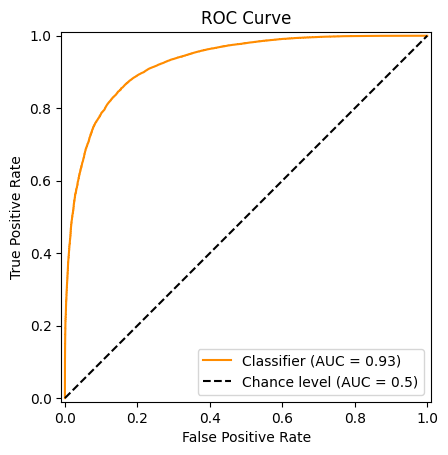

In [16]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test[:, 0],
    pred_test[:, 0],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve",
)

In [17]:
print(pred_test[...,0].shape, pred_test[...,0].min(), pred_test[...,0].max())

(54998,) 0.0003007161 1.0


In [18]:
from sklearn.metrics import f1_score, auc

pred_test[...,0][pred_test[...,0]>.5] = 1
pred_test[...,0][pred_test[...,0]<=.5] = 0

f1_score(y_test[...,0], pred_test[...,0], average='micro')

0.8529582893923415

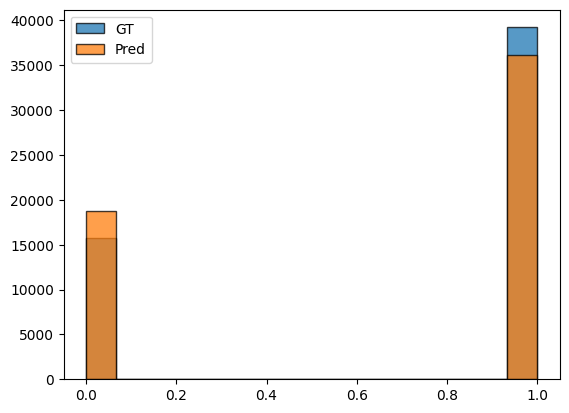

In [19]:
plt.hist(y_test[...,0], 15, alpha=0.75, edgecolor='k')
plt.hist(pred_test[...,0], 15, alpha=0.75, edgecolor='k')
plt.legend(['GT', 'Pred'])
plt.show()